In [1]:
import pandas as pd
import numpy as np

# from keras.layers.merge import dot
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot
from keras import backend as K

In [2]:
df = pd.read_csv('automotive.csv')
df

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,style,unixReviewTime
0,1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},1524096000
1,2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},1523836800
2,3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},1523577600
3,4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},1523145600
4,5,5,True,"03 24, 2018",AIY18YON1TWJJ,0209688726,{'Color:': ' Black'},1521849600
...,...,...,...,...,...,...,...,...
936191,1711514,5,True,"06 19, 2018",A3H86E5N0F1Q5R,B01HJFDJ8S,NaN,1529366400
936192,1711515,4,True,"08 23, 2017",AXH645B4SSAJY,B01HJFDJ8S,NaN,1503446400
936193,1711516,5,True,"08 8, 2017",AMGJLCCNVFB8,B01HJFDJ8S,NaN,1502150400
936194,1711517,5,True,"08 24, 2018",A1MJUNTX7CTR5U,B01HJI17Y8,{'Size:': ' H8-NEW'},1535068800


In [3]:
df = df.drop(columns=['Unnamed: 0', 'verified', 'reviewTime', 'style', 'unixReviewTime'])
df

,overall,reviewerID,asin
0,1,ABCA1A8E4DGV1,0209688726
1,1,A1NX8HM89FRQ32,0209688726
2,3,A1X77G023NY0KY,0209688726
3,5,A3GK37JO2MGW6Q,0209688726
4,5,AIY18YON1TWJJ,0209688726
...,...,...,...
936191,5,A3H86E5N0F1Q5R,B01HJFDJ8S
936192,4,AXH645B4SSAJY,B01HJFDJ8S
936193,5,AMGJLCCNVFB8,B01HJFDJ8S
936194,5,A1MJUNTX7CTR5U,B01HJI17Y8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936196 entries, 0 to 936195
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     936196 non-null  int64 
 1   reviewerID  936196 non-null  object
 2   asin        936196 non-null  object
dtypes: int64(1), object(2)
memory usage: 21.4+ MB


In [5]:
df.reviewerID = df.reviewerID.astype('category').cat.codes.values
df.asin = df.asin.astype('category').cat.codes.values

In [6]:
df['reviewerID'].value_counts(ascending=True)

38125       1
133015      1
25832       1
48371       1
34905       1
         ... 
70608     106
96063     114
106026    114
117724    123
37592     127
Name: reviewerID, Length: 161088, dtype: int64

In [7]:
df['overall'] = df['overall'].astype('float32')

In [8]:
df.isnull().sum()

overall       0
reviewerID    0
asin          0
dtype: int64

In [9]:
users = df.reviewerID.unique()
items = df.asin.unique()

userid2idx = {o:i for i,o in enumerate(users)}
itemid2idx = {o:i for i,o in enumerate(items)}

In [10]:
df['reviewerID'] = df['reviewerID'].apply(lambda x: userid2idx[x])
df['asin'] = df['asin'].apply(lambda x: itemid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(749199, 3) (186997, 3)


In [11]:
n_items = len(df['asin'].unique())
n_users = len(df['reviewerID'].unique())
n_latent_factors = 64  

In [12]:
user_input = Input(shape=(1,), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

In [13]:
item_input = Input(shape=(1,), name='item_input', dtype='int64')
item_embedding = Embedding(n_items, n_latent_factors, name='item_embedding')(item_input)
item_vec = Flatten(name='FlattenMovies')(item_embedding)

In [14]:
sim = Dot(name='Simalarity-Dot-Product',axes=1)([user_vec, item_vec])
model = Model([user_input, item_input],sim)

In [15]:
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [16]:
train.shape
batch_size = 128
epochs = 50

In [17]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('training.log', separator=',', append=False)

history = model.fit([train.reviewerID,train.asin],train.overall, batch_size=batch_size,
            epochs=epochs, validation_data = ([valid.reviewerID,valid.asin],valid.overall), verbose = 1)

Epoch 1/50
5854/5854 [==============================] - 246s 42ms/step - loss: 21.1179 - root_mean_squared_error: 4.5954 - val_loss: 20.7249 - val_root_mean_squared_error: 4.5525
Epoch 2/50
5854/5854 [==============================] - 248s 42ms/step - loss: 18.6630 - root_mean_squared_error: 4.3195 - val_loss: 17.4326 - val_root_mean_squared_error: 4.1752
Epoch 3/50
5854/5854 [==============================] - 242s 41ms/step - loss: 11.0417 - root_mean_squared_error: 3.3207 - val_loss: 12.8637 - val_root_mean_squared_error: 3.5866
Epoch 4/50
5854/5854 [==============================] - 243s 41ms/step - loss: 4.7067 - root_mean_squared_error: 2.1682 - val_loss: 10.3781 - val_root_mean_squared_error: 3.2215
Epoch 5/50
5854/5854 [==============================] - 258s 44ms/step - loss: 1.7338 - root_mean_squared_error: 1.3164 - val_loss: 9.4410 - val_root_mean_squared_error: 3.0726
Epoch 6/50
5854/5854 [==============================] - 253s 43ms/step - loss: 0.6083 - root_mean_squared_er

5854/5854 [==============================] - 294s 50ms/step - loss: 0.1287 - root_mean_squared_error: 0.3587 - val_loss: 6.7723 - val_root_mean_squared_error: 2.6024
Epoch 48/50
5854/5854 [==============================] - 290s 50ms/step - loss: 0.1283 - root_mean_squared_error: 0.3582 - val_loss: 6.7317 - val_root_mean_squared_error: 2.5946
Epoch 49/50
5854/5854 [==============================] - 256s 44ms/step - loss: 0.1272 - root_mean_squared_error: 0.3566 - val_loss: 6.6928 - val_root_mean_squared_error: 2.5870
Epoch 50/50
5854/5854 [==============================] - 258s 44ms/step - loss: 0.1269 - root_mean_squared_error: 0.3563 - val_loss: 6.6524 - val_root_mean_squared_error: 2.5792


In [18]:
# model.save("model")

In [19]:
# from tensorflow import keras
# model = keras.models.load_model('model')

In [21]:
item_em = model.get_layer('item_embedding')
item_em_weights = item_em.get_weights()[0]

<AxesSubplot:>

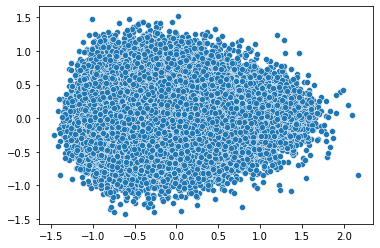

In [22]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [23]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

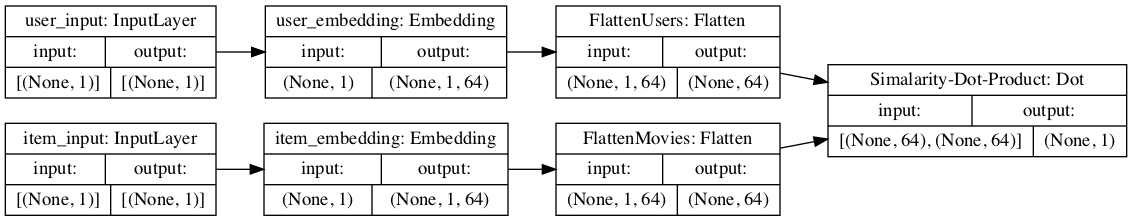

In [24]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='Model.png', rankdir='LR', show_shapes=True)
# Image(retina=True, filename='Model.png')

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


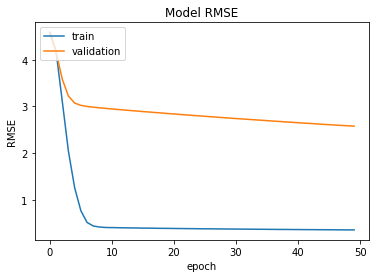

In [27]:
import matplotlib.pyplot as plt
print(history.history.keys())

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()